<a href="https://colab.research.google.com/github/HamzaQureshi12/My_Project_Code_For_Breast_Cancer_Classification/blob/main/Breast_Cancer_Classification_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Google Drive

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing The Libraries:

In [29]:
# Standard library for file and directory management
import os
# Library for numerical computations and handling arrays
import numpy as np
# Library for data manipulation and analysis (especially for CSV files)
import pandas as pd
# TensorFlow: Open-source library for machine learning and deep learning
import tensorflow as tf
# Metrics for evaluating model performance
from sklearn.metrics import *
# Matplotlib: Library for creating visualizations
import matplotlib.pyplot as plt
# Seaborn: Statistical data visualization library (built on Matplotlib)
import seaborn as sns
# TensorFlow utility for preprocessing image data, such as augmentations
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# TensorFlow again for deep learning and neural network functionalities
import tensorflow as tf
# Keras Sequential API for defining a model in a layer-by-layer manner
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Layers for convolutional neural networks (CNNs)
from tensorflow.keras.layers import (
    Conv2D,        # Convolutional layer for feature extraction
    MaxPooling2D,  # Max pooling layer for down-sampling
    Flatten,       # Flatten layer to convert 2D features to 1D
    Dense,         # Fully connected layer for classification
    Dropout,       # Dropout layer for regularization
    BatchNormalization, # Batch normalization for stabilizing training
    Input          # Input layer to define input shape
)
from sklearn.metrics import classification_report, confusion_matrix
# Regularizer for adding penalties to layer weights to prevent overfitting
from tensorflow.keras.regularizers import l2
# TensorFlow's data pipeline setting for optimizing performance
AUTOTUNE_SETTING = tf.data.experimental.AUTOTUNE
# Reading a CSV file containing information about data folds (e.g., train/test splits)
folds_data = pd.read_csv('/content/drive/MyDrive/Data Set/Folds.csv')
# Path to the folder containing the image dataset
image_folder_path = '/content/drive/MyDrive/Data Set/BreaKHis_v1/'
# Defining the two tumor classes in the dataset: benign and malignant
tumor_classes = ['benign', 'malignant']


# Removing the Duplicate Data From CSV

In [17]:
# Check for duplicate filenames
duplicate_count = folds_data['filename'].duplicated().sum()
print(f'Number of duplicate filenames: {duplicate_count}')

Number of duplicate filenames: 31636


In [18]:
# Remove duplicates based on the 'filename' column to keep only unique images
folds_data = folds_data.drop_duplicates(subset='filename', keep='first')

# Display the new shape of the DataFrame
print(f'New shape of the DataFrame: {folds_data.shape}')


New shape of the DataFrame: (7909, 4)


In [19]:
folds_data = folds_data.rename(columns={'filename': 'path'})
folds_data['label'] = folds_data.path.apply(lambda x: x.split('/')[3])
folds_data['label_int'] = folds_data.label.apply(lambda x: tumor_classes.index(x))
folds_data['file_name'] = folds_data.path.apply(lambda x: x.split('/')[-1])
folds_data['path'] = folds_data.path.apply(lambda x: image_folder_path + x)
folds_data.head(3)


,fold,mag,grp,path,label,label_int,file_name
0,1,100,train,/content/drive/MyDrive/Data Set/BreaKHis_v1/Br...,benign,0,SOB_B_A-14-22549AB-100-001.png
1,1,100,train,/content/drive/MyDrive/Data Set/BreaKHis_v1/Br...,benign,0,SOB_B_A-14-22549AB-100-002.png
2,1,100,train,/content/drive/MyDrive/Data Set/BreaKHis_v1/Br...,benign,0,SOB_B_A-14-22549AB-100-003.png


Count of Benign    :  2480
Count of Malignant :  5429


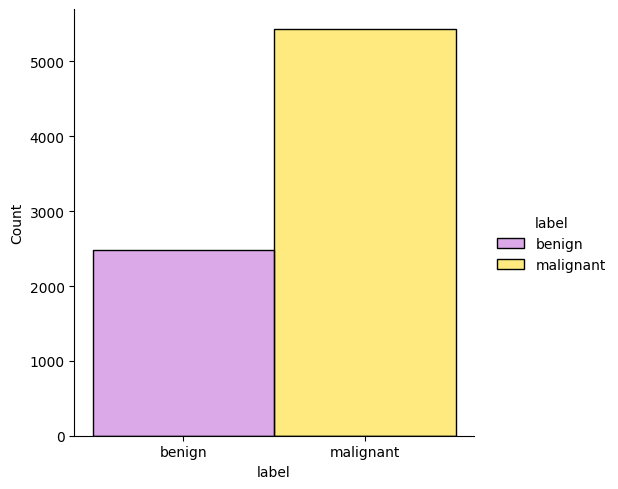

In [20]:
# Defining colors for benign and malignant
ax = sns.displot(
    data=folds_data,
    x='label',
    hue='label',
    palette={'benign': 'mediumorchid', 'malignant': 'gold'}
)

# Displaying count of each label
print('Count of Benign    : ', folds_data[folds_data.label == 'benign'].label.count())
print('Count of Malignant : ', folds_data[folds_data.label == 'malignant'].label.count())


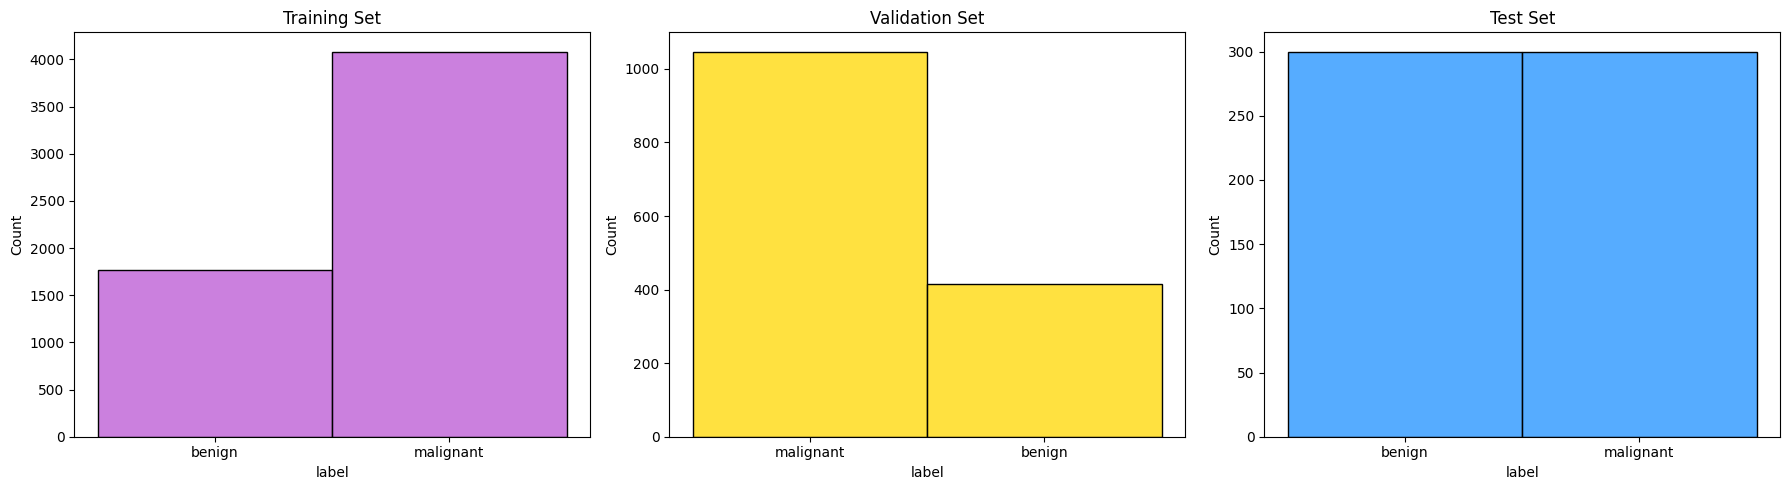

Training set
label
malignant    4082
benign       1765
Name: count, dtype: int64

Validation set
label
malignant    1047
benign        415
Name: count, dtype: int64

Test set
label
benign       300
malignant    300
Name: count, dtype: int64


In [21]:
# Remove 600 from dataset for testing
test_set = folds_data.groupby('label').sample(n=300)
train_set = folds_data.drop(test_set.index).reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

# Split training and validation set
validation_set = train_set.sample(frac=0.2)
train_set = train_set.drop(validation_set.index).reset_index(drop=True)
validation_set = validation_set.reset_index(drop=True)

# Assign sets and combine data
test_set['set'] = 'test'
train_set['set'] = 'train'
validation_set['set'] = 'valid'
combined_dataset = pd.concat([train_set, validation_set, test_set])

# Set up the figure with a row of three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot each distribution in a different color and assign to specific axes
sns.histplot(data=train_set, x='label', color='mediumorchid', ax=axes[0])
axes[0].set_title('Training Set')

sns.histplot(data=validation_set, x='label', color='gold', ax=axes[1])
axes[1].set_title('Validation Set')

sns.histplot(data=test_set, x='label', color='dodgerblue', ax=axes[2])
axes[2].set_title('Test Set')

# Show the plots in a row
plt.tight_layout()
plt.show()

# Print counts for each set
print('Training set')
print(train_set.label.value_counts())

print('\nValidation set')
print(validation_set.label.value_counts())

print('\nTest set')
print(test_set.label.value_counts())


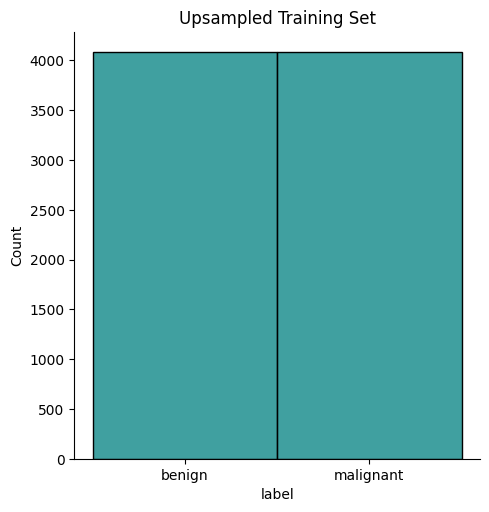

label
benign       4082
malignant    4082
Name: count, dtype: int64


In [22]:
# Upsample training dataset
max_count = np.max(train_set.label.value_counts())
train_set = train_set.groupby('label').sample(n=max_count, replace=True).reset_index(drop=True)

# Plot distribution after upsampling
ax = sns.displot(data=train_set, x='label', color='teal')
ax.set(title='Upsampled Training Set')
plt.show()

# Display counts to verify upsampling
print(train_set.label.value_counts())


# Data Augmentation

In [23]:
# Convert label_int to string type for categorical class mode
train_set['label_int'] = train_set['label_int'].astype(str)
validation_set['label_int'] = validation_set['label_int'].astype(str)

# Data augmentation setup
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Use a simpler validation generator with rescaling only
valid_datagen = ImageDataGenerator(rescale=1./255)

# Update the variable names in the data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_set,  # Updated from train_data to train_set
    directory='',
    x_col='path',
    y_col='label_int',
    target_size=(150, 150),
    batch_size=32,
    class_mode='sparse'
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=validation_set,  # Updated from valid_data to validation_set
    directory='',
    x_col='path',
    y_col='label_int',
    target_size=(150, 150),
    batch_size=32,
    class_mode='sparse'
)


Found 8164 validated image filenames belonging to 2 classes.
Found 1462 validated image filenames belonging to 2 classes.


# Model Archtecture

In [24]:
# Regularization strength
regularization_strength = 0.001

# Build the model
model = Sequential()

# Input layer
model.add(Input(shape=(150, 150, 3)))

# First convolutional block
model.add(Conv2D(32, (3, 3), activation='relu', padding='same',
                 kernel_regularizer=l2(regularization_strength)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same',
                 kernel_regularizer=l2(regularization_strength)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Second convolutional block
model.add(Conv2D(64, (3, 3), activation='relu', padding='same',
                 kernel_regularizer=l2(regularization_strength)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same',
                 kernel_regularizer=l2(regularization_strength)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

# Third convolutional block
model.add(Conv2D(128, (3, 3), activation='relu', padding='same',
                 kernel_regularizer=l2(regularization_strength)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same',
                 kernel_regularizer=l2(regularization_strength)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

# Fourth convolutional block
model.add(Conv2D(256, (3, 3), activation='relu', padding='same',
                 kernel_regularizer=l2(regularization_strength)))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu', padding='same',
                 kernel_regularizer=l2(regularization_strength)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(regularization_strength)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(regularization_strength)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer
model.add(Dense(2, activation='softmax', kernel_regularizer=l2(regularization_strength)))  # Adjust for binary classification

In [25]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 150, 150, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 75, 75, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 37, 37, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 37, 37, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 18, 18, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 18, 18, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 6,517,538 (24.86 MB)

 Trainable params: 6,515,810 (24.86 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [26]:
# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',     # Metric to monitor
        patience=10,            # Number of epochs with no improvement to stop training
        restore_best_weights=True  # Restore weights from the epoch with the best value of the monitored metric
    ),
    ReduceLROnPlateau(
        monitor='val_loss',       # Metric to monitor
        factor=0.1,               # Factor by which to reduce the learning rate
        patience=5,               # Number of epochs with no improvement before reducing
        verbose=1
    ),

]

# Train the model with callbacks
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,
    verbose=1,
    callbacks=callbacks  # Pass the callbacks to the fit method
)

# Save the trained model
model.save('custom_cnn_model_breast_cancer.h5')

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


256/256 ━━━━━━━━━━━━━━━━━━━━ 2798s 10s/step - accuracy: 0.7287 - loss: 2.2146 - val_accuracy: 0.7161 - val_loss: 2.4230 - learning_rate: 0.0010
Epoch 2/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 203s 771ms/step - accuracy: 0.7988 - loss: 1.5969 - val_accuracy: 0.7401 - val_loss: 1.3600 - learning_rate: 0.0010
Epoch 3/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 201s 768ms/step - accuracy: 0.8354 - loss: 1.1857 - val_accuracy: 0.8687 - val_loss: 1.1846 - learning_rate: 0.0010
Epoch 4/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 201s 768ms/step - accuracy: 0.8487 - loss: 0.9424 - val_accuracy: 0.8290 - val_loss: 0.8784 - learning_rate: 0.0010
Epoch 5/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 200s 766ms/step - accuracy: 0.8605 - loss: 0.7520 - val_accuracy: 0.7182 - val_loss: 1.1398 - learning_rate: 0.0010
Epoch 6/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 201s 764ms/step - accuracy: 0.8706 - loss: 0.6315 - val_accuracy: 0.9029 - val_loss: 0.5520 - learning_rate: 0.0010
Epoch 7/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 202s 763ms/step - accuracy: 0.8857 -

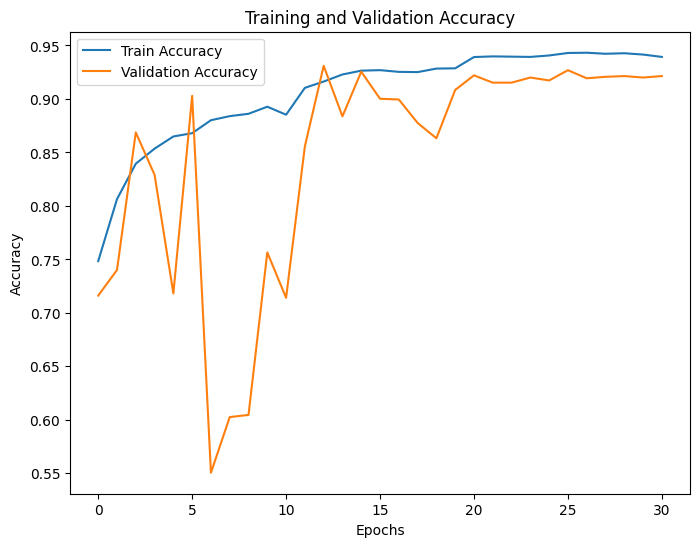

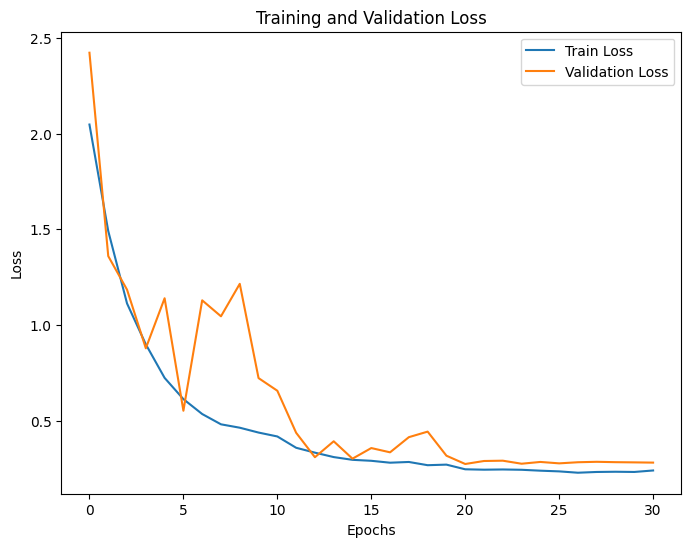

In [28]:
def plot_training_history(history):
    """
    Plots the training history of a model, including accuracy and loss for training and validation.

    Args:
        history (keras.callbacks.History): The history object returned by the `fit` method of a Keras model.
    """
    # Plot accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(history.history.get('accuracy', []), label='Train Accuracy')
    plt.plot(history.history.get('val_accuracy', []), label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    # Plot loss
    plt.figure(figsize=(8, 6))
    plt.plot(history.history.get('loss', []), label='Train Loss')
    plt.plot(history.history.get('val_loss', []), label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Call the function to plot the graphs
plot_training_history(history)

# Test the Model on Test Set

In [36]:
# Convert label_int column to string type
test_set['label_int'] = test_set['label_int'].astype(str)
# Ensure the test set is configured properly
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_set,  # Pandas DataFrame with test data
    directory='',        # Directory is empty if paths are absolute
    x_col='path',        # Column with file paths
    y_col='label_int',   # Column with label strings
    target_size=(150, 150),  # Resize images to match model input
    batch_size=32,       # Batch size for the generator
    class_mode='sparse', # Sparse for integer labels (as strings now)
    shuffle=False        # Do not shuffle to keep order for evaluation
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Generate predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class indices
true_classes = test_generator.classes               # True class labels
class_labels = list(test_generator.class_indices.keys())  # Class names

Found 600 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 258s 14s/step - accuracy: 0.8634 - loss: 0.3949
Test Accuracy: 0.89
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 530ms/step


# Classification Report and Confusion Matrix


Classification Report:
               precision    recall  f1-score   support

      Benign       0.95      0.83      0.89       300
   Malignant       0.85      0.96      0.90       300

    accuracy                           0.90       600
   macro avg       0.90      0.90      0.89       600
weighted avg       0.90      0.90      0.89       600



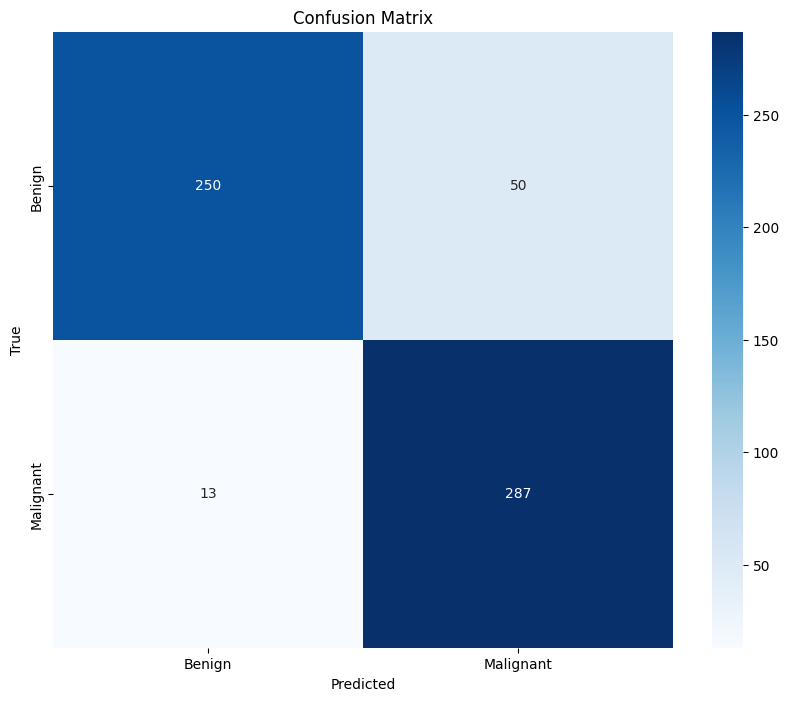

In [38]:
# Define class label mapping
class_labels = ["Benign", "Malignant"]
# Classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("\nClassification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()